# Classifying Based on Phoneme Length

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy import signal, stats

import sys
sys.path.append('../../../')
from speech2phone.preprocessing.TIMIT.phones import get_data, get_phones, phones

np.set_printoptions(precision=2)

### Load Data

In [2]:
def resample(data, y):
    """Resample audio to 800 points."""
    return signal.resample(data, 800), y

In [5]:
audio, labels = get_data(preprocessor=None, batch_preprocess=False, TIMIT_root='../../TIMIT/TIMIT', padding=0)
phonemes = get_phones(labels)
n_phones = len(phones)

Loading train/none/0 set from cache... done.


In [10]:
len(labels)

132810

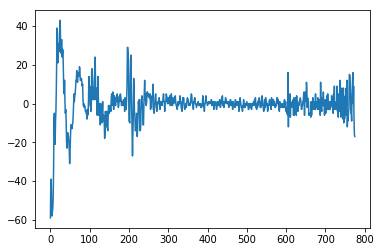

In [6]:
plt.plot(audio[0])

In [9]:
phones

array(['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ax-h', 'axr', 'ay', 'b',
       'bcl', 'ch', 'd', 'dcl', 'dh', 'dx', 'eh', 'el', 'em', 'en', 'eng',
       'epi', 'er', 'ey', 'f', 'g', 'gcl', 'h#', 'hh', 'hv', 'ih', 'ix',
       'iy', 'jh', 'k', 'kcl', 'l', 'm', 'n', 'ng', 'nx', 'ow', 'oy', 'p',
       'pau', 'pcl', 'q', 'r', 's', 'sh', 't', 'tcl', 'th', 'uh', 'uw',
       'ux', 'v', 'w', 'y', 'z', 'zh'], dtype='<U4')

### Phoneme Frequency

[0.02 0.02 0.01 0.02 0.   0.02 0.   0.02 0.01 0.01 0.01 0.   0.02 0.03
 0.02 0.02 0.02 0.01 0.   0.   0.   0.01 0.01 0.01 0.01 0.01 0.01 0.05
 0.01 0.01 0.03 0.05 0.04 0.01 0.03 0.03 0.03 0.02 0.04 0.01 0.01 0.01
 0.   0.01 0.01 0.01 0.02 0.04 0.04 0.01 0.02 0.04 0.   0.   0.   0.01
 0.01 0.02 0.01 0.02 0.  ]
0.05217980573751976 0.00021835705142685038


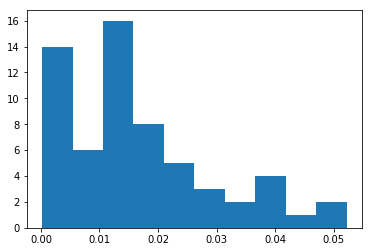

In [57]:
label_freq = np.array([
    (labels == i).mean()
    for i in range(n_phones)
])
print(label_freq)

print(label_freq.max(), label_freq.min())
plt.hist(label_freq)
plt.show()

### Phoneme Length

[ 776  880 1046 ...  960 1351  794]
47950 32


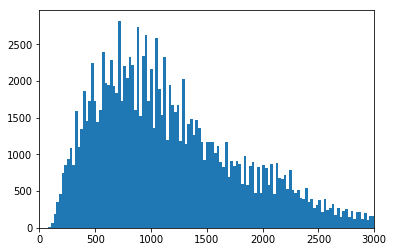

In [8]:
length_freq = np.array([
    len(audio[i])
    for i in range(len(audio))
])
print(length_freq)

# print(sorted(length_freq)[::-1])
print(length_freq.max(), length_freq.min())
plt.hist(length_freq, bins=2000)
plt.xlim([0, 3000])
plt.show()

[1939.92 2380.47 1417.12 2001.52 2568.79  772.71  523.18 1302.58 2302.38
  278.09 1008.38 1385.86  372.33  811.28  606.63  457.55 1459.35 1445.13
 1319.68 1270.25 1345.86  686.14 1883.53 2022.57 1657.56  474.22  800.87
 3100.03 1034.49 1092.11 1252.98  821.7  1444.22  926.59  828.57  951.16
  960.52  976.25  868.38  987.18  463.71 2004.01 2577.34  711.59 2928.63
 1114.17 1038.5   973.56 1804.69 1844.67  768.49  873.96 1479.28 1229.95
 1687.19 1720.3   972.55 1062.64 1059.94 1343.91 1314.55]
[ 600.11  710.55  561.98  712.94  821.61  281.44  257.71  485.41  866.36
  113.03  391.37  451.86  204.22  406.41  313.    121.29  544.18  518.17
  575.6   481.8   388.58  345.81  623.48  641.55  555.21  201.91  364.22
 2703.13  499.04  369.36  447.81  311.47  566.97  404.79  412.42  414.64
  359.18  398.86  358.78  365.58  112.33  629.83  615.23  346.66 2020.46
  389.69  498.76  395.31  604.57  476.83  383.14  483.27  612.57  504.98
  714.14  852.59  346.4   520.8   553.67  500.1   423.62]


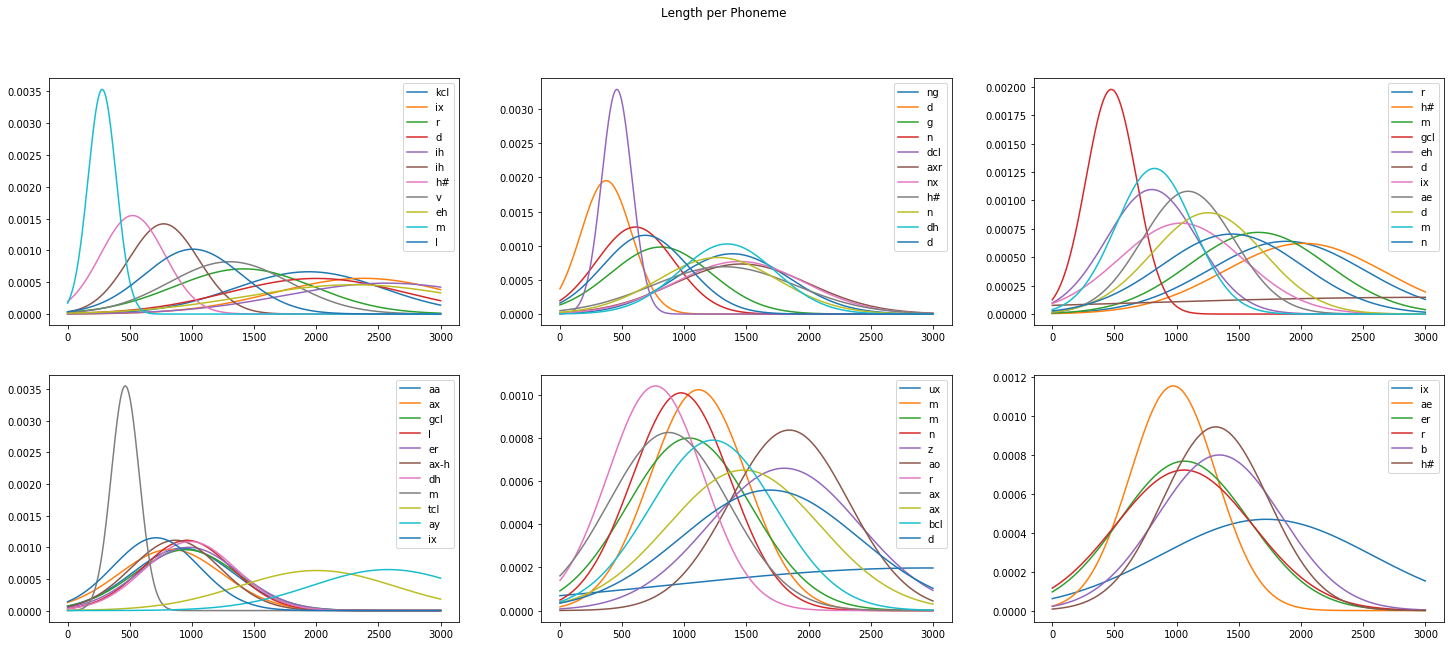

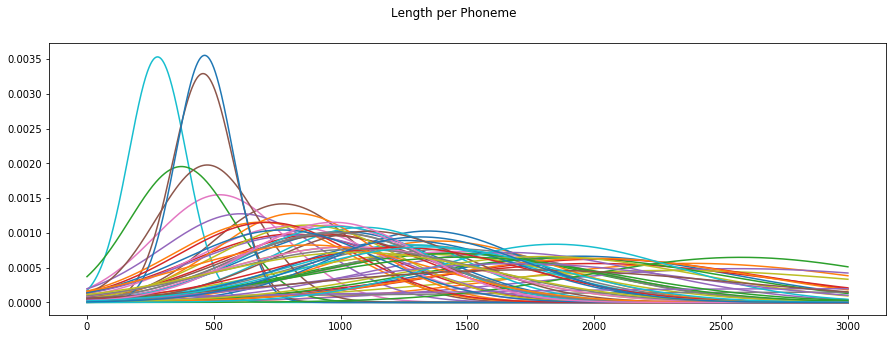

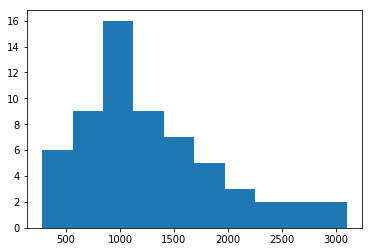

In [113]:
average_length = np.array([
    length_freq[labels == i].mean()
    for i in range(n_phones)
])

length_std = np.array([
    length_freq[labels == i].std()
    for i in range(n_phones)
])

print(average_length)
print(length_cov)

fig, axs = plt.subplots(2, 3, figsize=(25,10))
domain = np.linspace(0, 3000, 3000)
for j in range(6):
    for i in range(j*11, min(61, (j+1)*11)):
        pdf = stats.norm.pdf(x=domain, loc=average_length[i], scale=length_std[i])
        axs.flatten()[j].plot(domain, pdf, label=phonemes[i])
    axs.flatten()[j].legend()
plt.suptitle("Length per Phoneme")
plt.savefig('phoneme_length.png')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(15,5))
for i in range(n_phones):
    pdf = stats.norm.pdf(x=domain, loc=average_length[i], scale=length_std[i])
    ax.plot(domain, pdf)
plt.suptitle("Length per Phoneme")
plt.savefig('phoneme_length_together.png')
plt.show()

plt.hist(average_length)
plt.show()

['ih' 'ax' 'm' ... 'l' 'dh' 'eh']
['gcl' 'm' 'n' ... 'b' 'r' 'g']


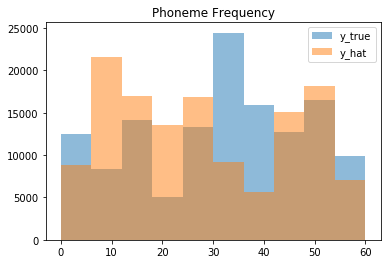

Nearest Mean Length Accuracy: 0.053


In [95]:
def predict_means(X, y):
    n_points = len(X)
    lengths = np.array([
        len(X[i])
        for i in range(n_points)
    ]) # (n_points,)
    
    average_lengths = np.array([
        lengths[y == i].mean()
        for i in range(n_phones)
    ]) # (n_phonemes,)
    
    dists = np.abs(np.expand_dims(lengths, 1) - np.expand_dims(average_lengths, 0))
    y_hat = np.argmin(dists, axis=1)
    
    print(phonemes[y_hat])
    print(phonemes[y])
    
    plt.hist(y, alpha=0.5, label="y_true")
    plt.hist(y_hat, alpha=0.5, label="y_hat")
    plt.legend()
    plt.title("Phoneme Frequency")
    plt.show()
    
    acc = (y_hat == y).mean()
    print("Nearest Mean Length Accuracy: {:.3f}".format(acc))
    
predict_means(audio, labels)

In [27]:
print(audio.shape, labels.shape)
n_data = 1000
X, y = audio[:n_data], labels[:n_data]
print(X.shape, y.shape)

(132810,) (132810,)
(1000,) (1000,)


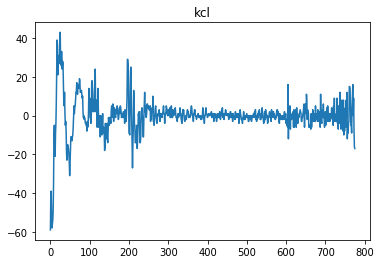

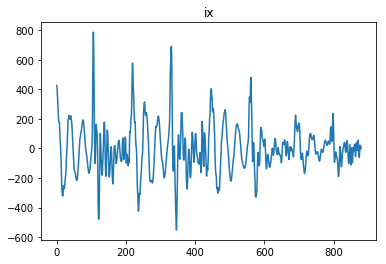

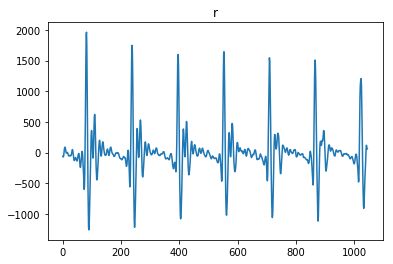

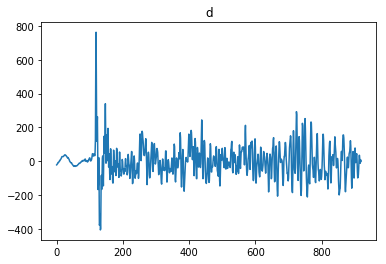

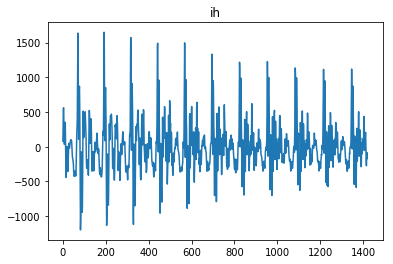

In [39]:
def plot_sample(i, title):
    plt.plot(audio[i])
    plt.title(title)
    plt.show()
    
for i in range(5):
    plot_sample(i, title=phonemes[i])

In [24]:
labels

array([35, 31, 47, ..., 59, 58, 13])